# Analyzing the metadata of the youtuber's videos

In [1]:
import polars as pl
from plotnine import ggplot, geom_point, geom_col, geom_line, aes, labs, theme, element_text, scale_x_datetime, scale_x_discrete, facet_wrap, guides, geom_smooth, coord_flip, geom_text
from mizani.breaks import date_breaks
from mizani.formatters import date_format

#### The youtuber to be analyzed

In [2]:
video_file = "./corpus/tatiana_ventose_videos.csv"
ytb = "tatiana_ventose"
ytb_name = "Tatiana Ventôse"

In [3]:
videos = pl.read_csv(video_file).with_columns(
    pl.col('published_at').str.to_datetime(),
    pl.col('duration').str.replace_all("^PT([0-9]{1,2})S$", "00:00:$1").str.replace_all("^PT([0-9]{1,2})M([0-9]{1,2})S$", "00:$1:$2").str.replace_all("^PT([0-9]{1,2})H([0-9]{1,2})M([0-9]{1,2})S$", "$1:$2:$3").str.replace_all("^PT([0-9]{1,2})M$", "00:$1:00").str.to_time("%H:%M:%S"),
    pl.col("tags").str.replace_all("^$", "Not_provided").str.split(by="|"),
    pl.col("topics").str.replace_all("^$", "Not_provided").str.split(by="|"),
    pl.col("gensim_topics").str.split(by="|"),
    pl.col("comment_count").fill_null(-1),
    pl.col("view_count").fill_null(-1),
    pl.col("like_count").fill_null(-1)
)

## The views of the videos

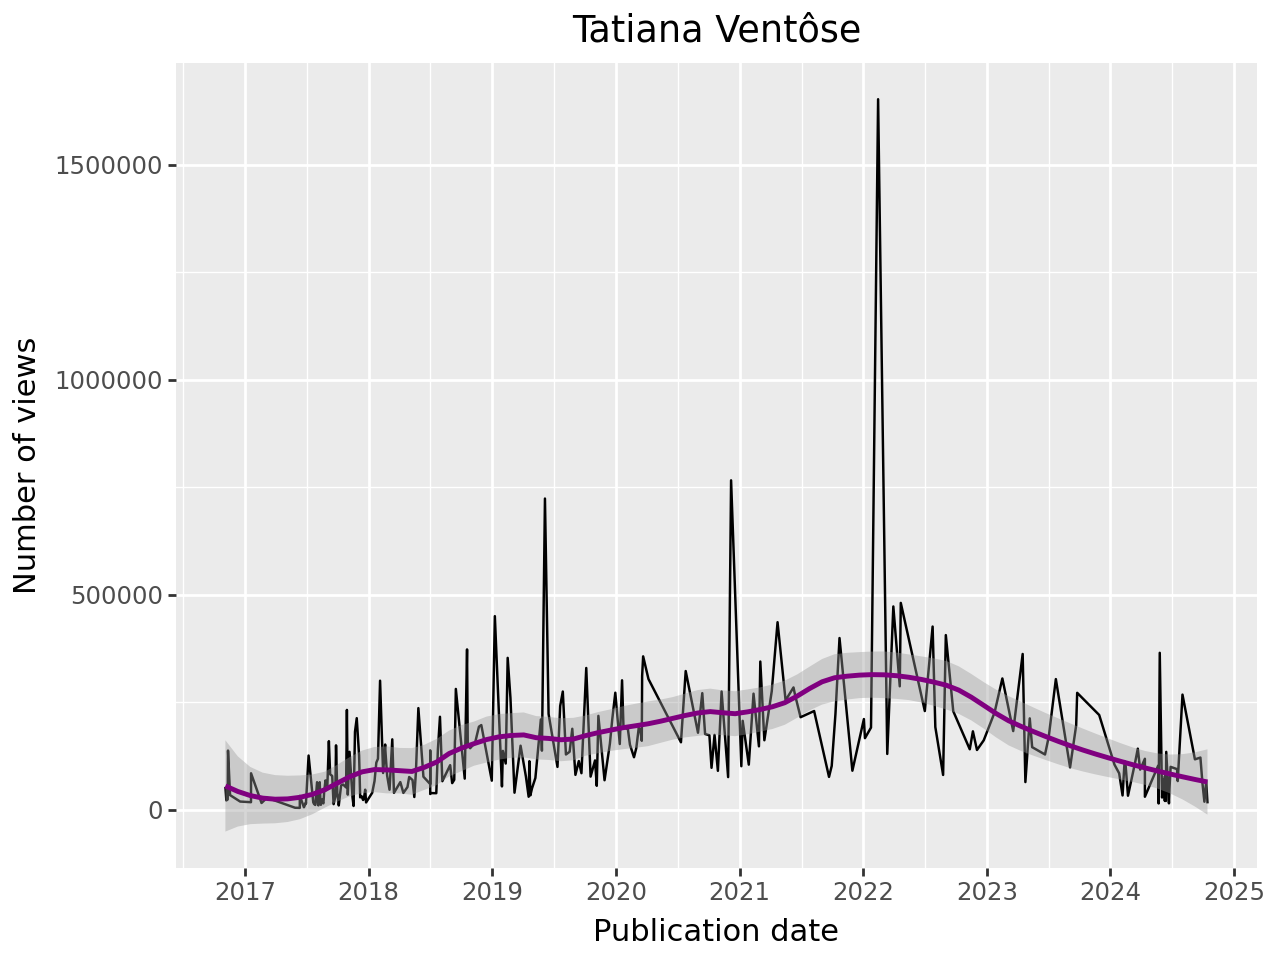

In [4]:
p = ( 
    ggplot(videos, aes("published_at", "view_count"))
    + geom_line()
    + geom_smooth(span=0.3, se=True, method="loess", color="purple")
    + scale_x_datetime(breaks=date_breaks("1 year"), labels=date_format("%Y"))
    + labs(title=ytb_name, x="Publication date", y="Number of views")
)
p.show()

In [5]:
# the most viewed videos
videos.sort("view_count", descending=True).select(['video_title', 'view_count', 'published_at', 'gensim_topics']).head(15)

video_title,view_count,published_at,gensim_topics
str,i64,"datetime[μs, UTC]",list[str]
"""L'AFFAIRE QUI PEUT FAIRE TOMBE…",1652299,2022-02-13 16:00:28 UTC,"[""9""]"
"""POURQUOI J'AI QUITTÉ LA GAUCHE…",765874,2020-12-06 10:00:10 UTC,"[""1""]"
"""CE QUI CLOCHE AVEC GRETA THUNB…",723509,2019-06-05 15:24:56 UTC,"[""17""]"
"""CENSURE, AUTOCENSURE, CHANTAGE…",480811,2022-04-21 15:23:47 UTC,"[""1"", ""11""]"
"""QUE FAIRE ?""",472522,2022-03-30 15:30:06 UTC,"[""1""]"
…,…,…,…
"""COMMENT MÉLENCHON A MIS FIN À …",372600,2018-10-18 12:43:40 UTC,"[""16""]"
"""Ils ont détruit le pays, et ma…",364720,2024-05-25 13:18:47 UTC,"[""19""]"
"""CE QUE MACRON A VRAIMENT ÉTÉ F…",362028,2023-04-16 16:00:00 UTC,"[""5"", ""9"", ""19""]"


## The YouTube categories of the videos

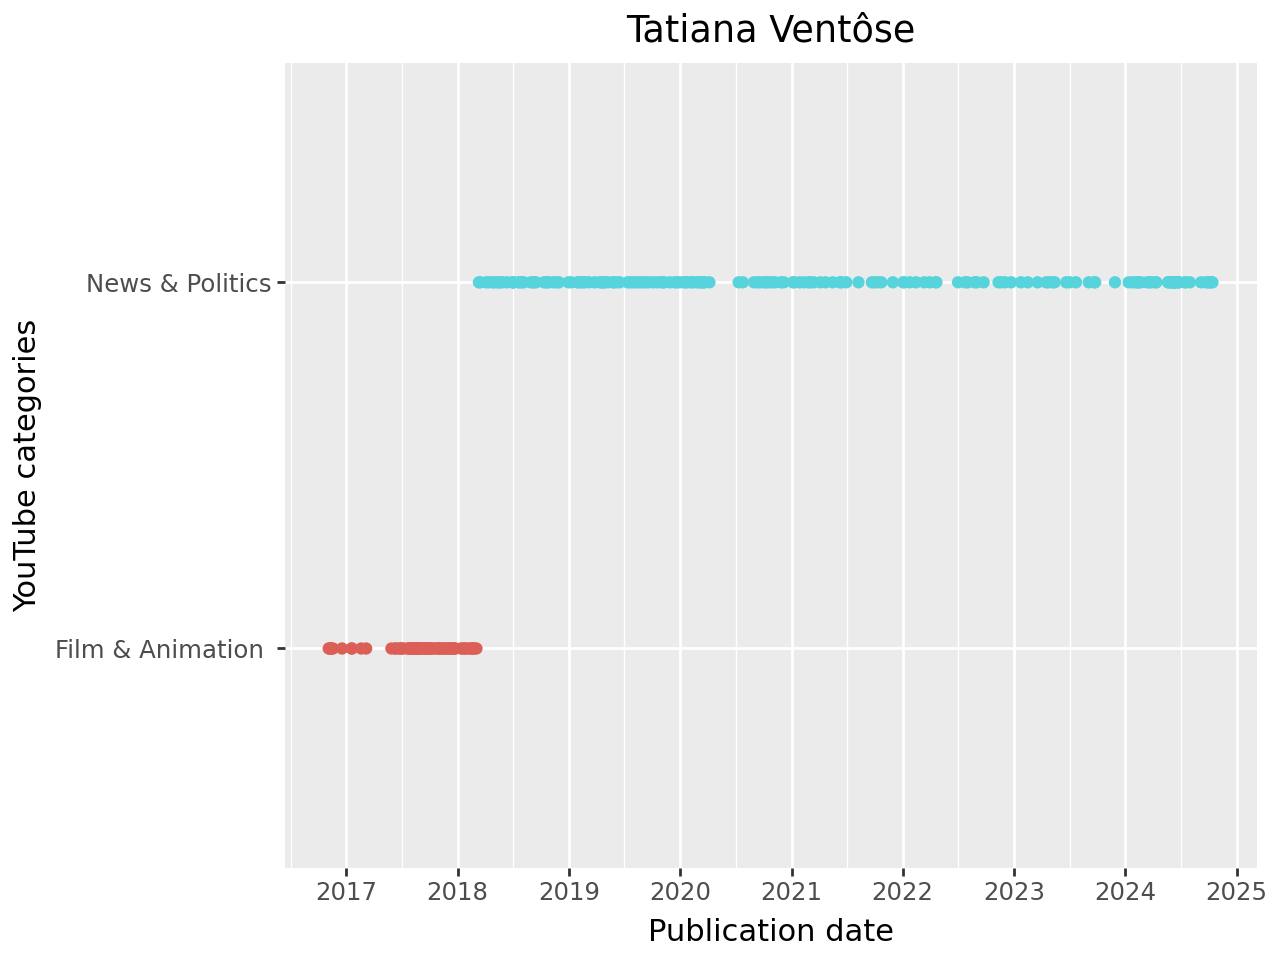

In [6]:
p = (
    ggplot(videos, aes("published_at", "category", color="factor(category)")) 
    + geom_point() 
    + scale_x_datetime(breaks=date_breaks("1 year"), labels=date_format("%Y")) 
    + labs(color="Categories", title=ytb_name, x="Publication date", y="YouTube categories") 
    + guides(color=False) # no legend
)
p.show()

## The YouTube topics of the videos

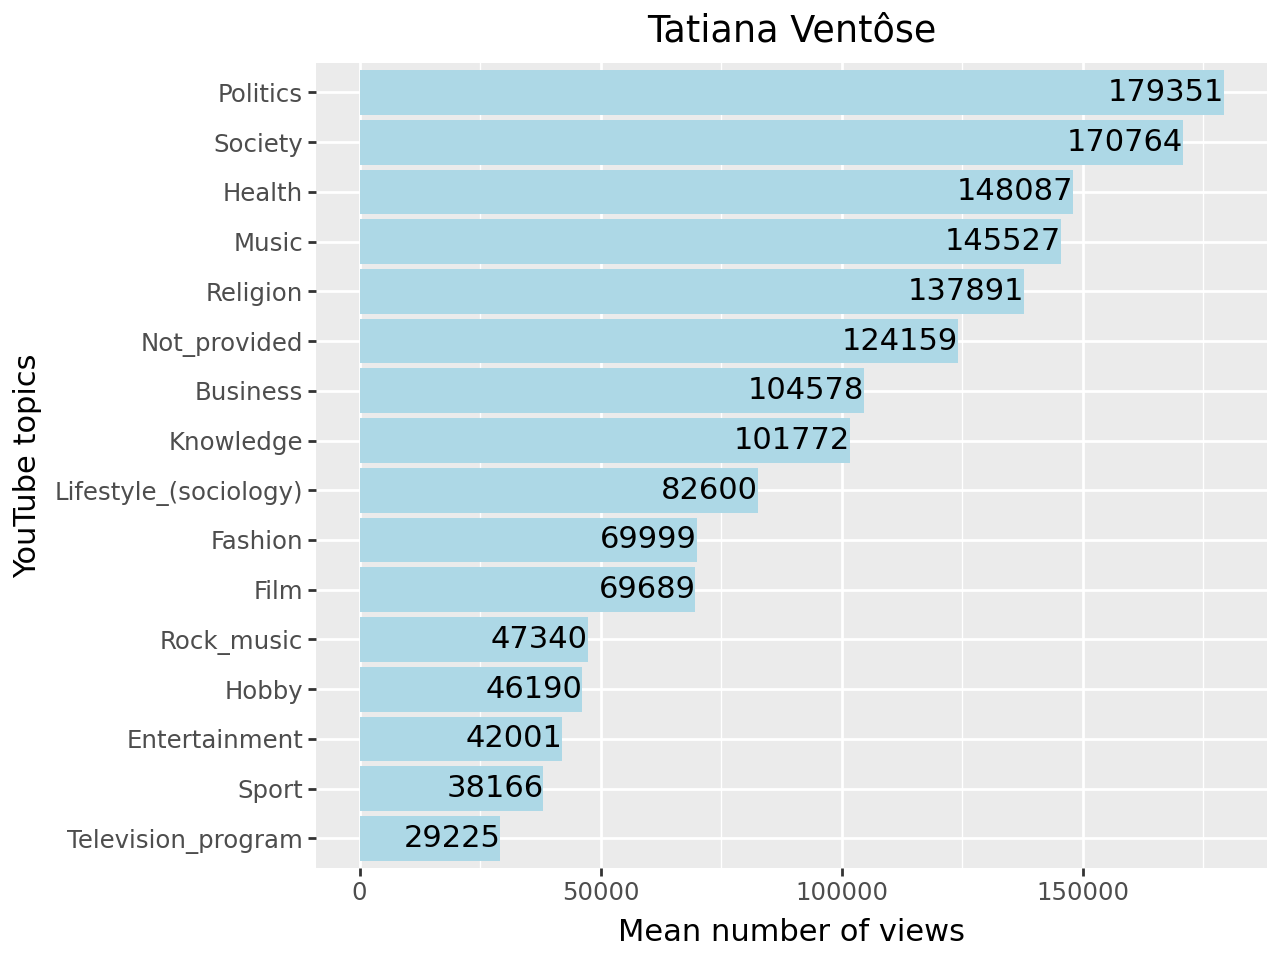

In [7]:
v = videos.explode("topics").select(['topics', 'view_count']).group_by("topics").mean().sort("view_count")
p = (
    ggplot(v, aes("topics", "view_count")) 
    + geom_col(fill="lightblue") 
    + coord_flip() 
    + geom_text(aes(label='view_count'), va='center', ha='right', format_string='{:.0f}') 
    + scale_x_discrete(limits=v['topics'].to_list()) 
    + labs(title=ytb_name, x="YouTube topics", y="Mean number of views")
)
p.show()

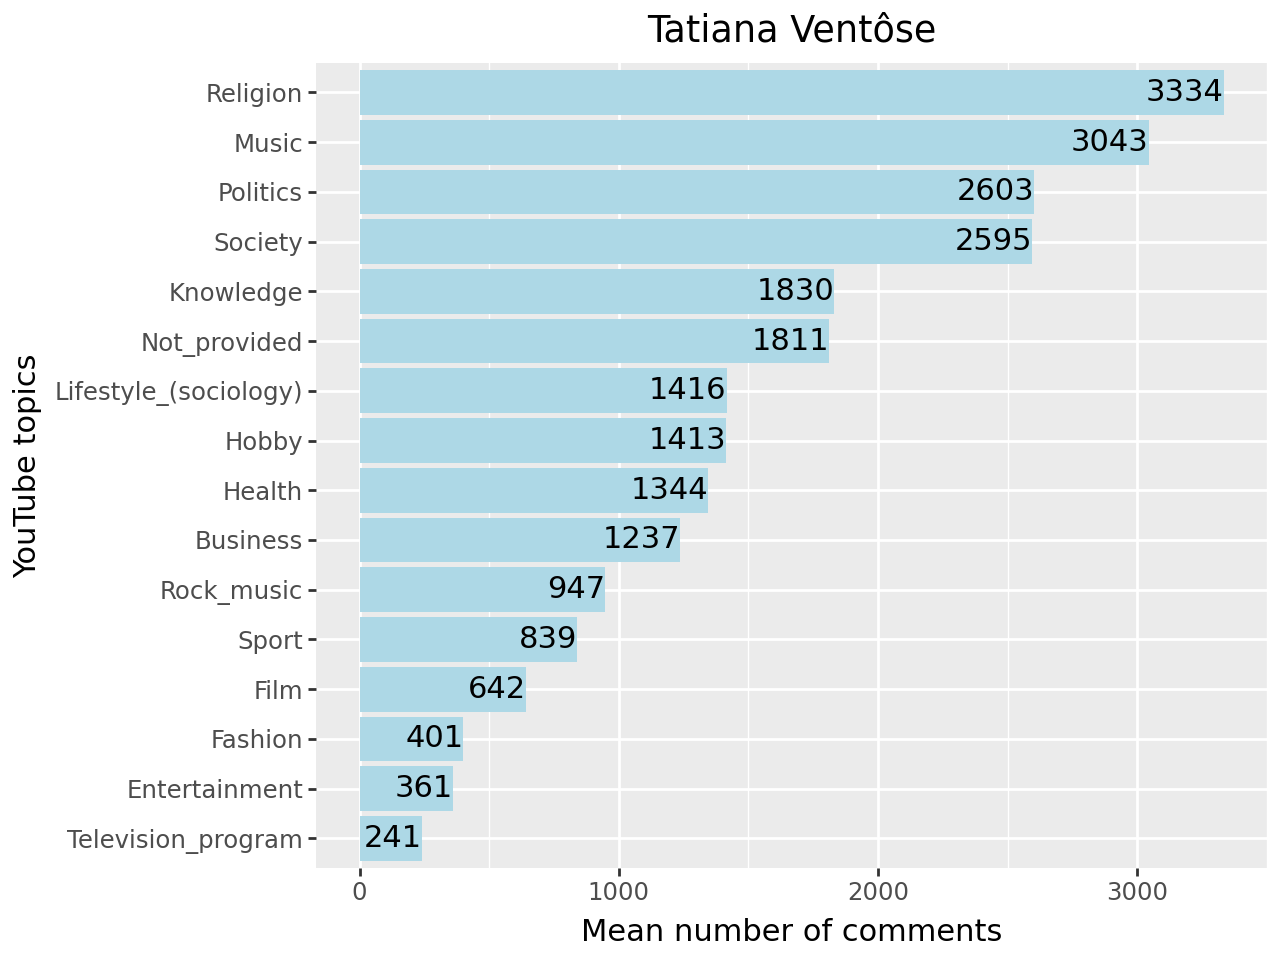

In [8]:
v = videos.explode("topics").select(['topics', 'comment_count']).group_by("topics").mean().sort("comment_count")
p = (
    ggplot(v, aes("topics", "comment_count")) 
    + geom_col(fill="lightblue") 
    + coord_flip() 
    + geom_text(aes(label='comment_count'), va='center', ha='right', format_string='{:.0f}') 
    + labs(title=ytb_name, x="YouTube topics", y="Mean number of comments") 
    + scale_x_discrete(limits=v['topics'].to_list()) 
    + guides(fill=False)
)
p.show()

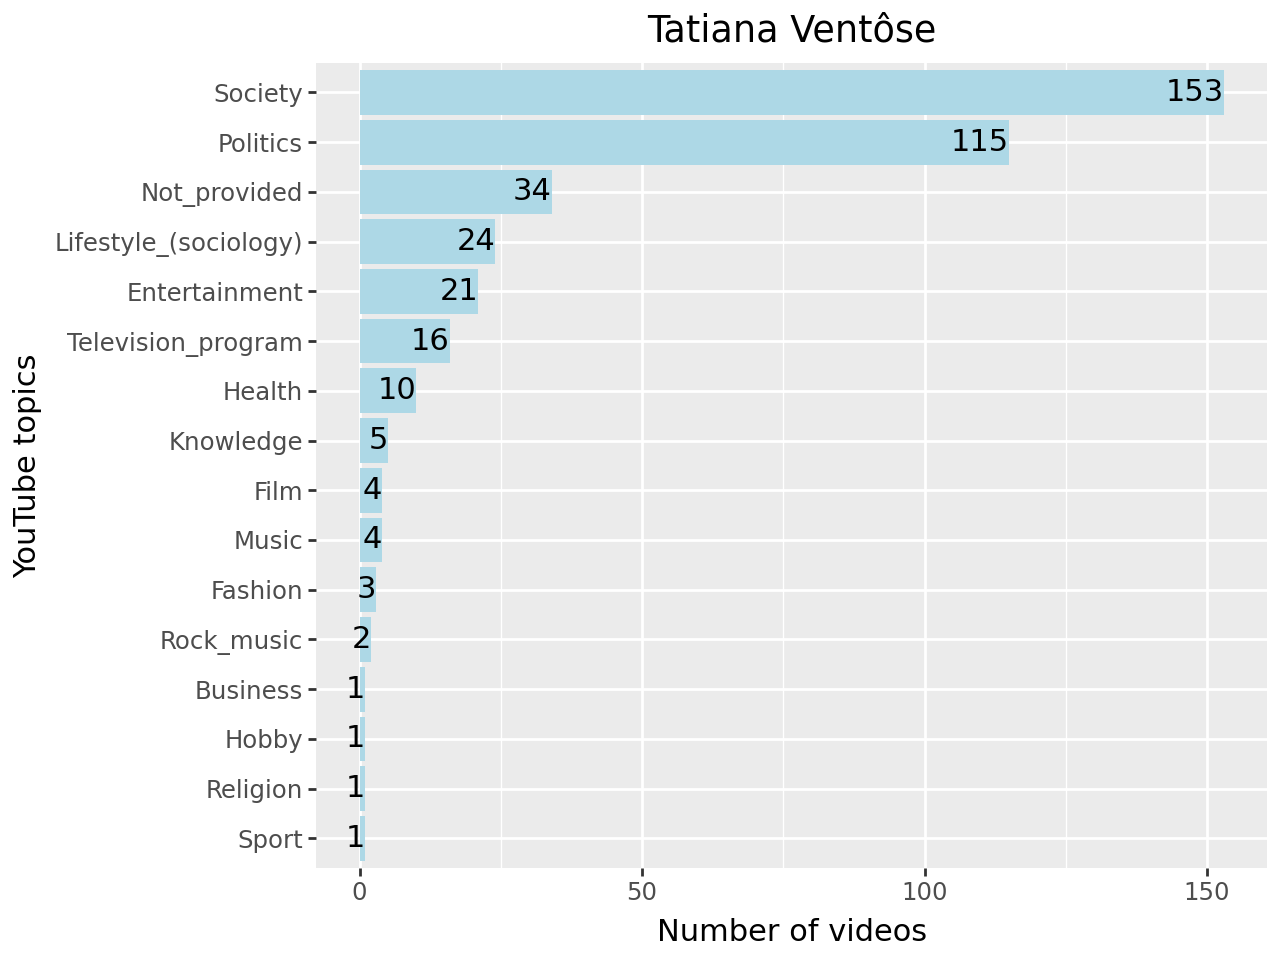

In [9]:
topic_counts = videos['topics'].explode().value_counts().sort(by="count")
p = (
    ggplot(topic_counts, aes(x='topics', y='count')) 
    + geom_col(fill='lightblue') 
    + coord_flip() 
    + geom_text(aes(label='count'), va='center', ha='right', format_string='{:.0f}') 
    + labs(title=ytb_name, x="YouTube topics", y="Number of videos") 
    + scale_x_discrete(limits=topic_counts['topics'].to_list())
)
p.show()

In [10]:
tc_by_year = pl.DataFrame()
topics = videos['topics'].explode().unique().to_list()

for date in [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]:

    filtered_videos = videos.filter(pl.col('published_at').is_between(pl.date(date, 1, 1), pl.date(date, 12, 31)))
    tc = filtered_videos['topics'].explode().value_counts()

    missing_topics = set(topics) - set(tc['topics'])
    missing_rows = pl.DataFrame({'topics': list(missing_topics), 'count': [0] * len(missing_topics),}).with_columns(pl.col('count').cast(pl.UInt32))
    tc = pl.concat([tc, missing_rows]).with_columns(pl.lit(date).alias('year'))
    
    tc_by_year = pl.concat([tc_by_year, tc])

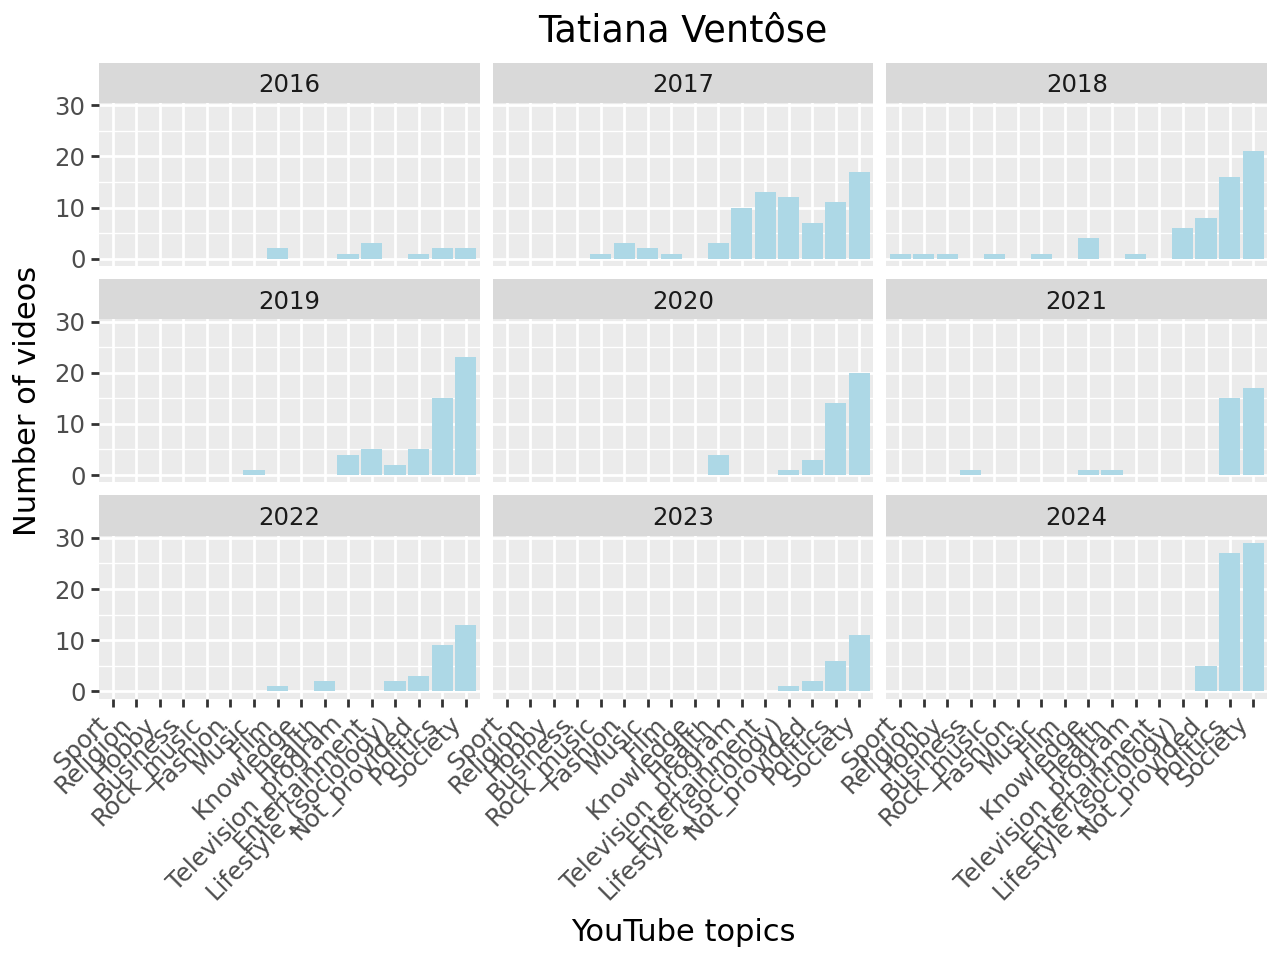

In [11]:
# facet_wrap: track the appearance of topics year by year
p = (
    ggplot(tc_by_year, aes(x='topics', y='count')) 
    + geom_col(fill='lightblue') 
    + labs(title=ytb_name, x="YouTube topics", y="Number of videos") 
    + theme(axis_text_x=element_text(angle=45, hjust=1)) 
    + scale_x_discrete(limits=topic_counts['topics'].to_list()) 
    + facet_wrap("year")
)
p.show()

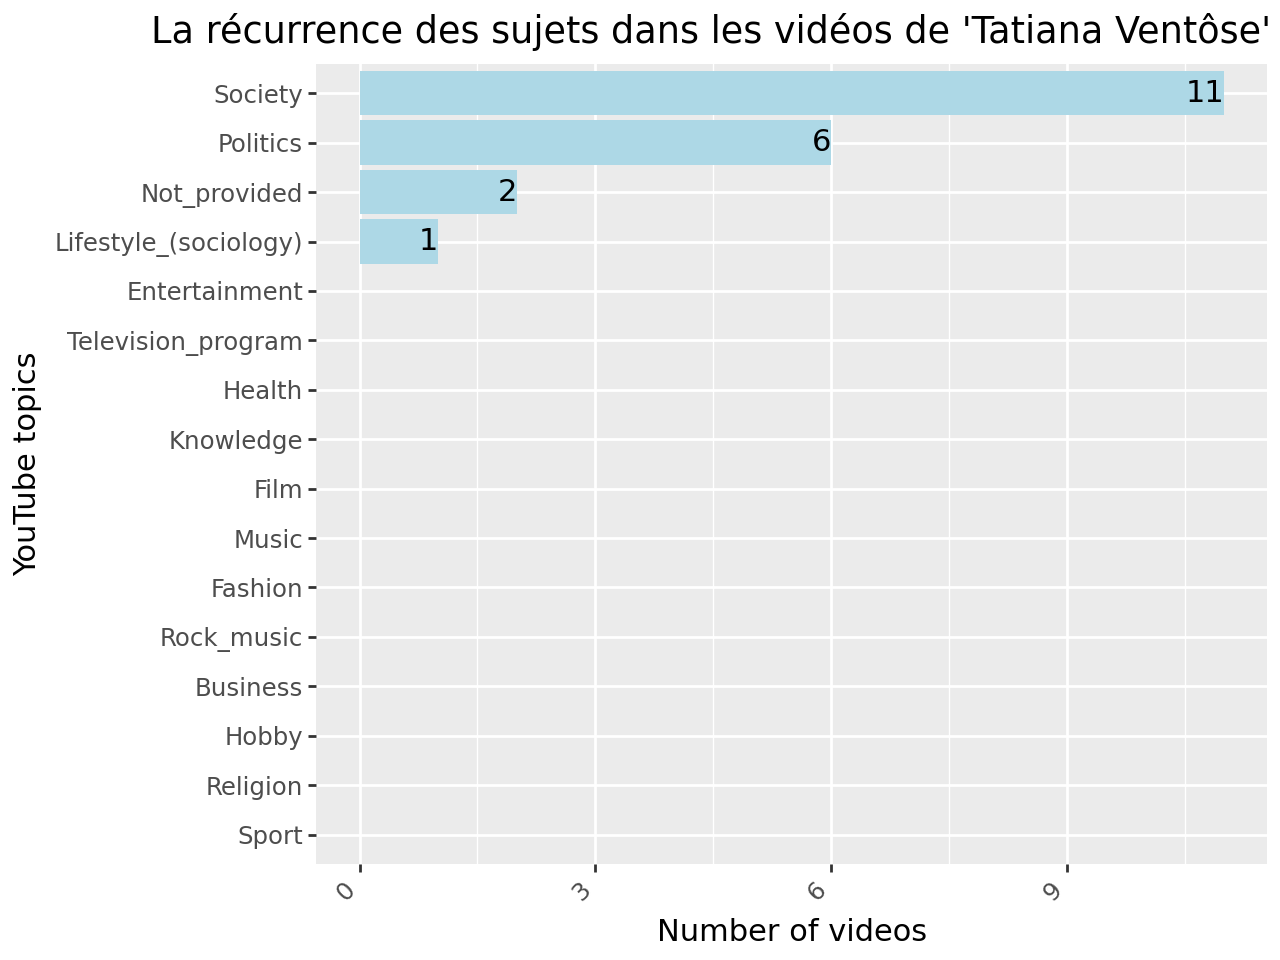

In [12]:
year = 2023 # choose a year
filtered_videos = videos.filter(pl.col('published_at').is_between(pl.date(year, 1, 1), pl.date(year, 12, 31)))
tc = filtered_videos['topics'].explode().value_counts().sort(by='count')

p = (
    ggplot(tc, aes(x='topics', y='count')) 
    + geom_col(fill='lightblue') 
    + coord_flip() 
    + geom_text(aes(label='count'), va='center', ha='right', format_string='{:.0f}') 
    + labs(title=f"La récurrence des sujets dans les vidéos de '{ytb_name}' en {date}", x="YouTube topics", y="Number of videos") 
    + theme(axis_text_x=element_text(angle=45, hjust=1)) 
    + scale_x_discrete(limits=topic_counts['topics'].to_list())
)
p.show()

## The YouTube tags of the videos

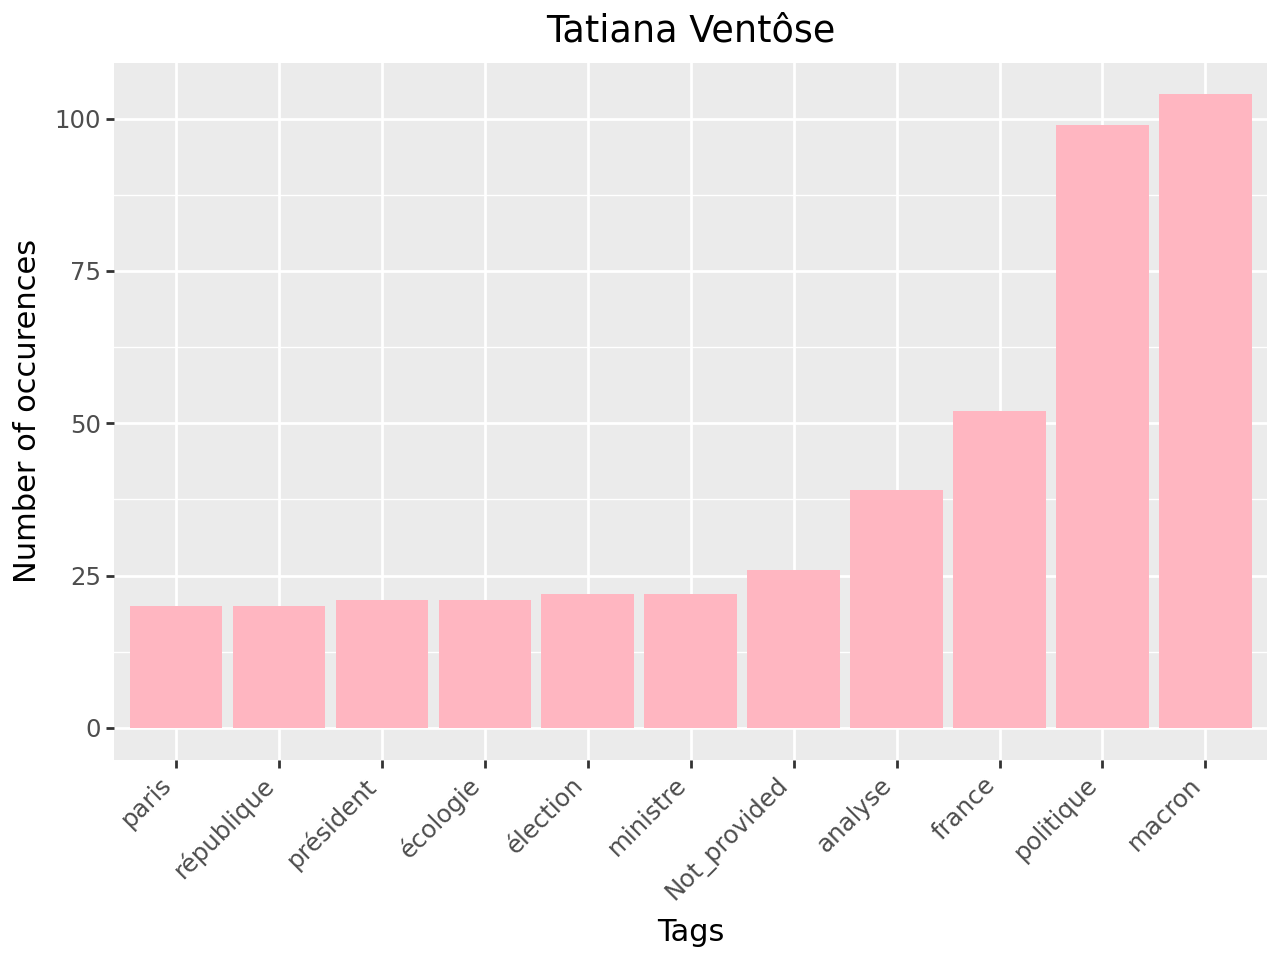

In [13]:
# most used tags by the youtuber
n = 20 # from how many recurrences is needed for a tag to appear
tag_counts = videos['tags'].explode().value_counts().sort(by="count").filter(pl.col('count') >= n)
p = (
    ggplot(tag_counts, aes(x='tags', y='count')) 
    + geom_col(fill='lightpink') 
    + labs(title=ytb_name, x="Tags", y="Number of occurences") 
    + theme(axis_text_x=element_text(angle=45, hjust=1)) 
    + scale_x_discrete(limits=tag_counts['tags'].to_list())
)
p.show()

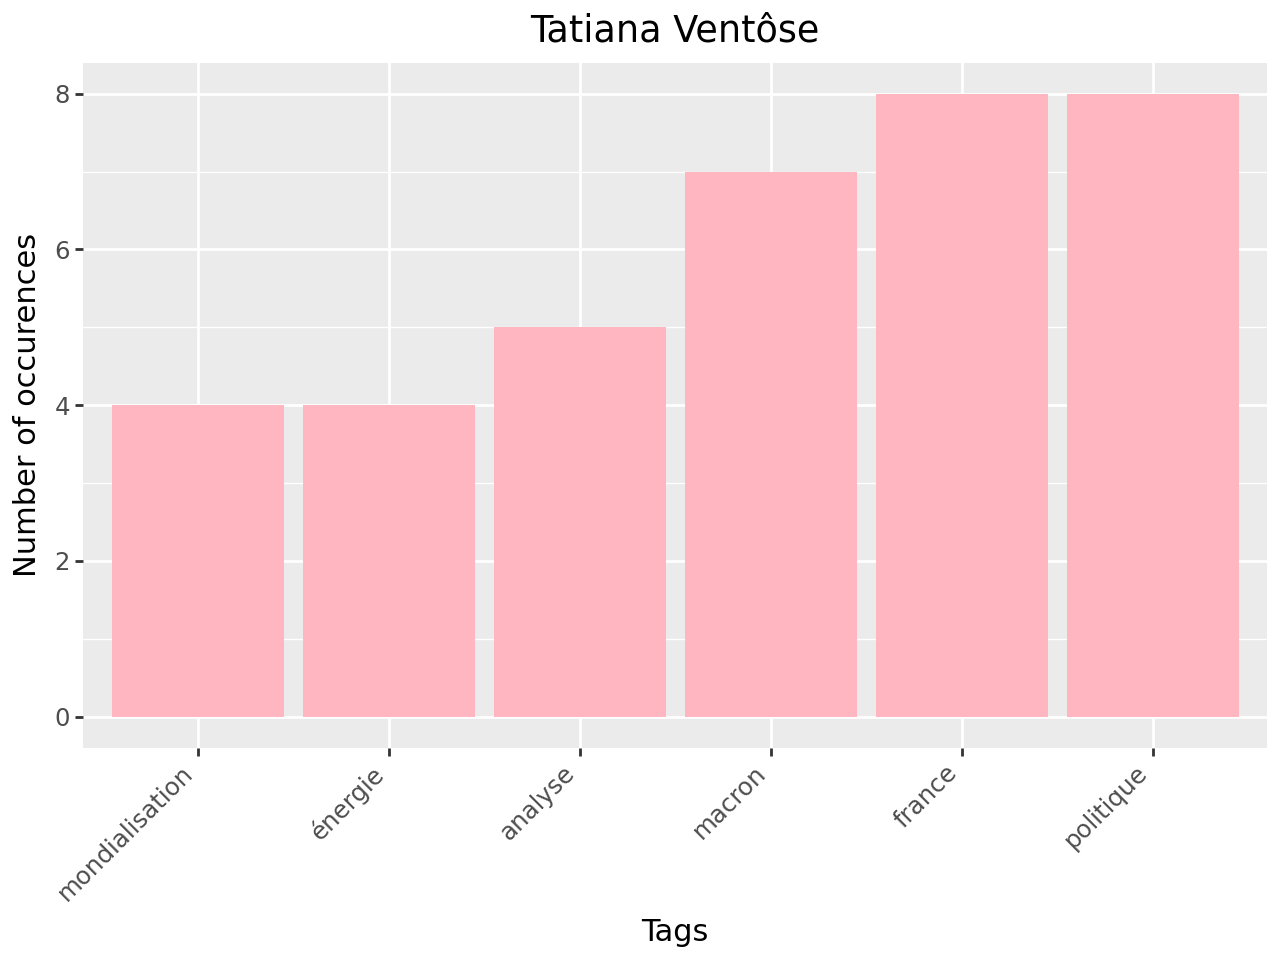

In [14]:
year = 2023 # choose a year
n = 4 # from how many recurrences is needed for a tag to appear

filtered_videos = videos.filter(pl.col('published_at').is_between(pl.date(year, 1, 1), pl.date(year, 12, 31)))
tc = filtered_videos['tags'].explode().value_counts().sort(by="count").filter(pl.col('count') >= n)

p = (
    ggplot(tc, aes(x='tags', y='count')) 
    + geom_col(fill='lightpink') 
    + labs(title=ytb_name, x="Tags", y="Number of occurences") 
    + theme(axis_text_x=element_text(angle=45, hjust=1)) 
    + scale_x_discrete(limits=tc['tags'].to_list())
)
p.show()

## Gensim Topics

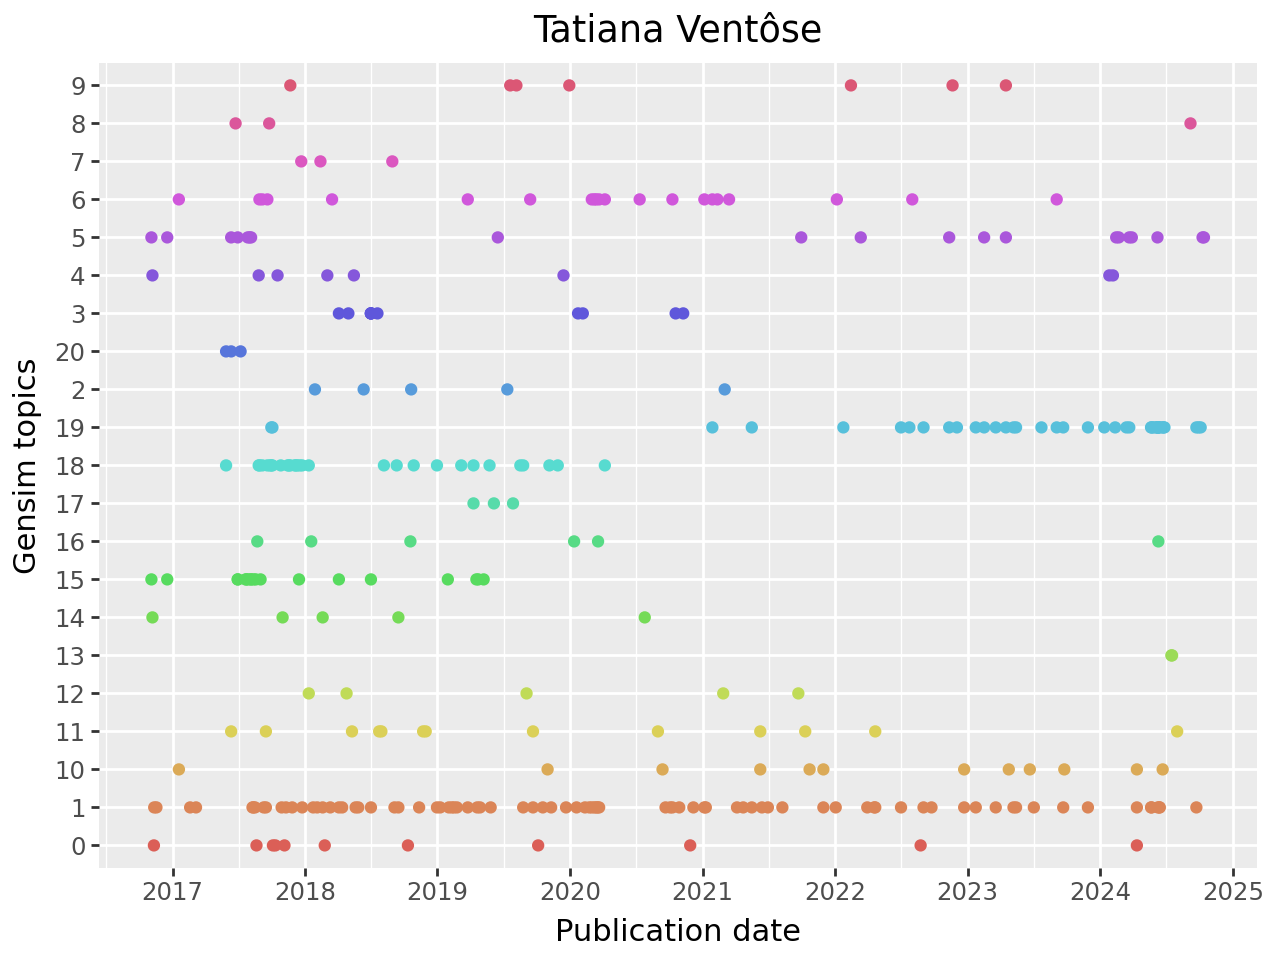

In [16]:
v = videos.explode("gensim_topics")
p = (
    ggplot(v, aes("published_at", "gensim_topics", color="factor(gensim_topics)")) 
    + geom_point() 
    + scale_x_datetime(breaks=date_breaks("1 year"), labels=date_format("%Y")) 
    + labs(color="Gensim Topics", title=ytb_name, x="Publication date", y="Gensim topics") 
    + guides(color=False)
)
p.show()

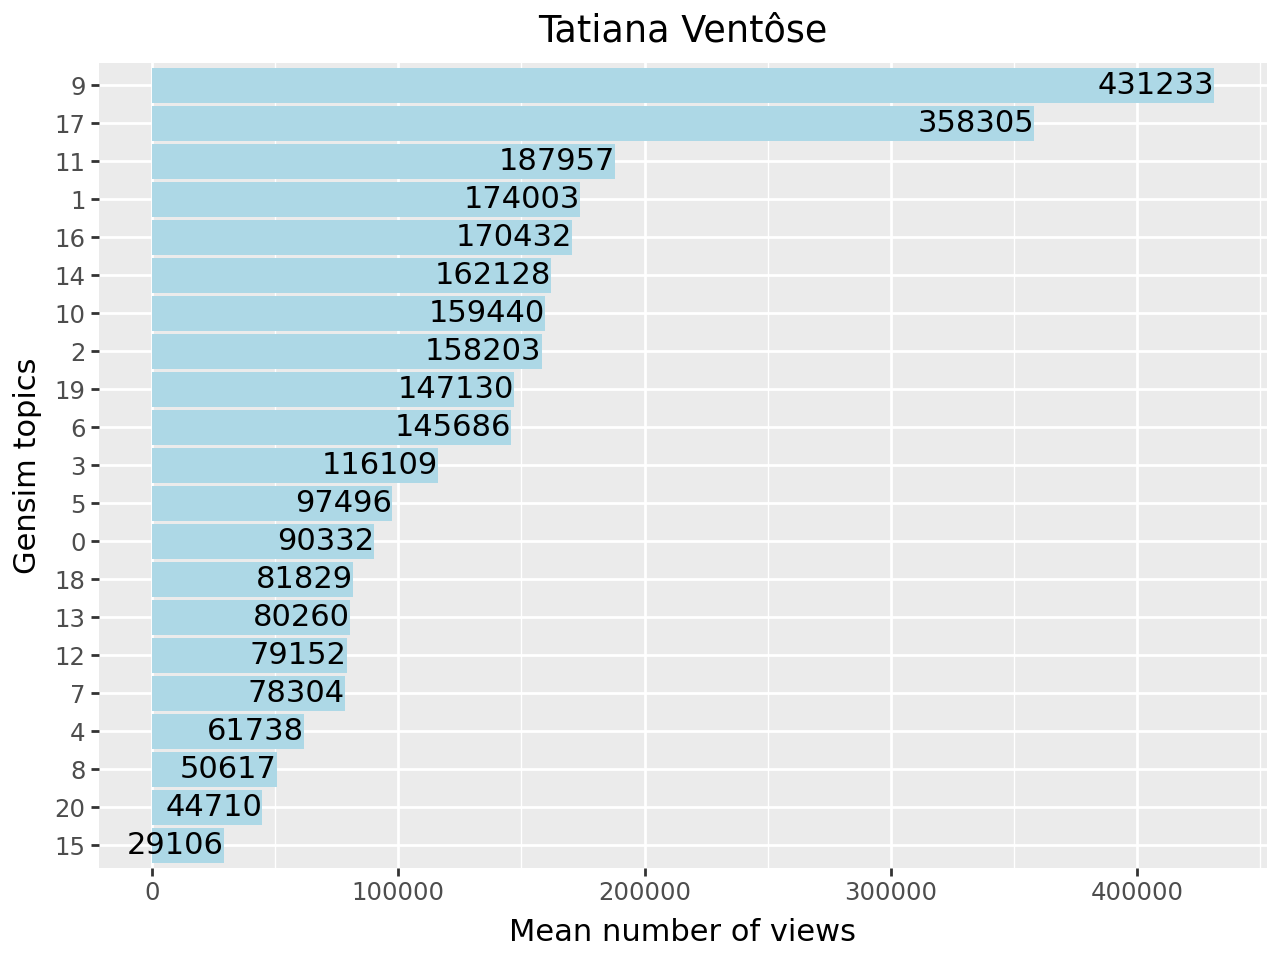

In [17]:
v = videos.explode("gensim_topics").select(['gensim_topics', 'view_count']).group_by("gensim_topics").mean().sort("view_count")
p = (
    ggplot(v, aes("gensim_topics", "view_count")) 
    + geom_col(fill="lightblue") 
    + coord_flip() 
    + geom_text(aes(label='view_count'), va='center', ha='right', format_string='{:.0f}') 
    + scale_x_discrete(limits=v['gensim_topics'].to_list()) 
    + labs(title=ytb_name, x="Gensim topics", y="Mean number of views")
)
p.show()

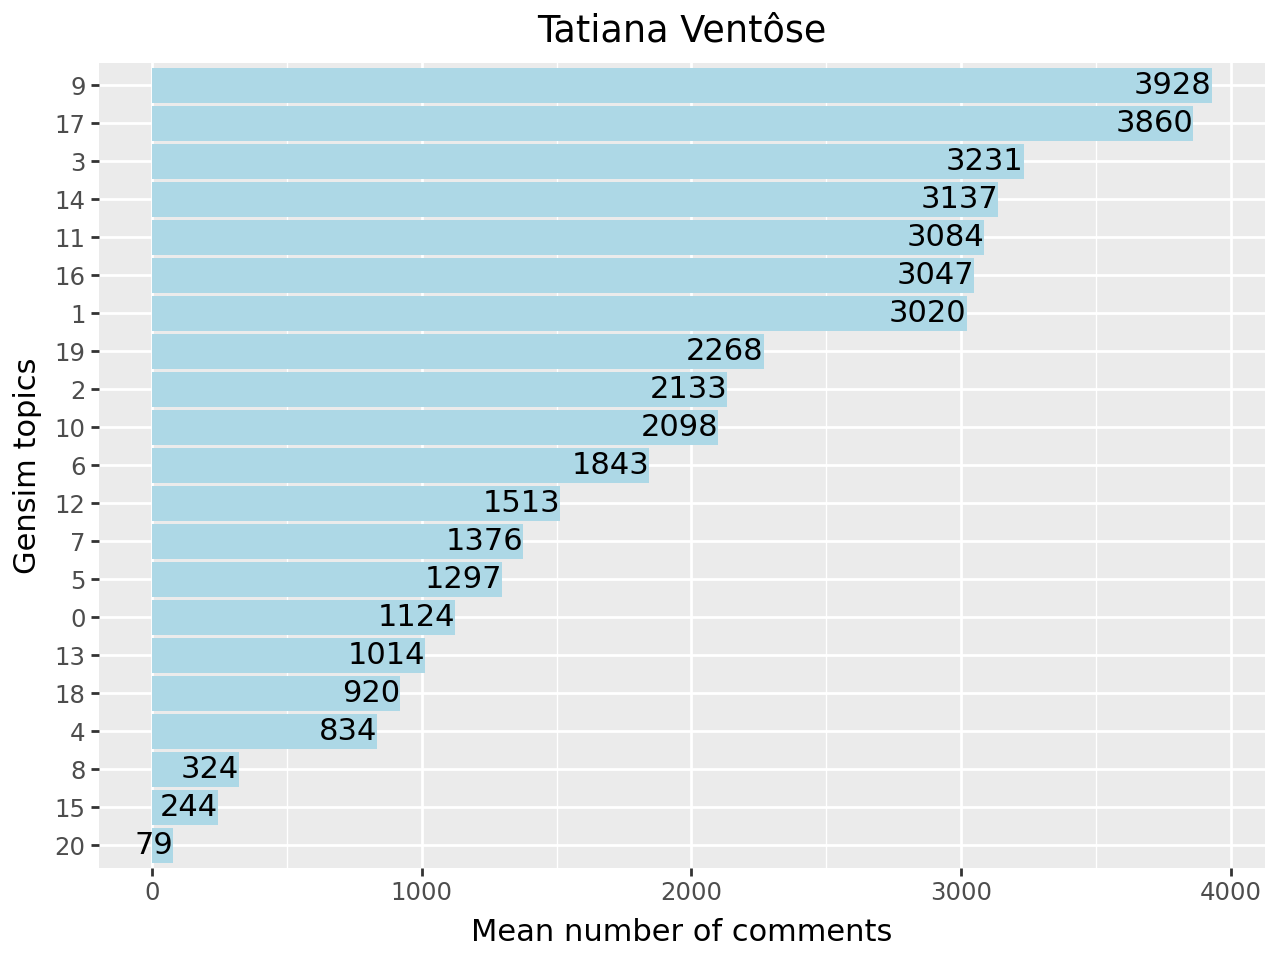

In [18]:
v = videos.explode("gensim_topics").select(['gensim_topics', 'comment_count']).group_by("gensim_topics").mean().sort("comment_count")
p = (
    ggplot(v, aes("gensim_topics", "comment_count")) 
    + geom_col(fill="lightblue") 
    + coord_flip() 
    + geom_text(aes(label='comment_count'), va='center', ha='right', format_string='{:.0f}') 
    + labs(title=ytb_name, x="Gensim topics", y="Mean number of comments") 
    + scale_x_discrete(limits=v['gensim_topics'].to_list()) 
    + guides(fill=False)
)
p.show()

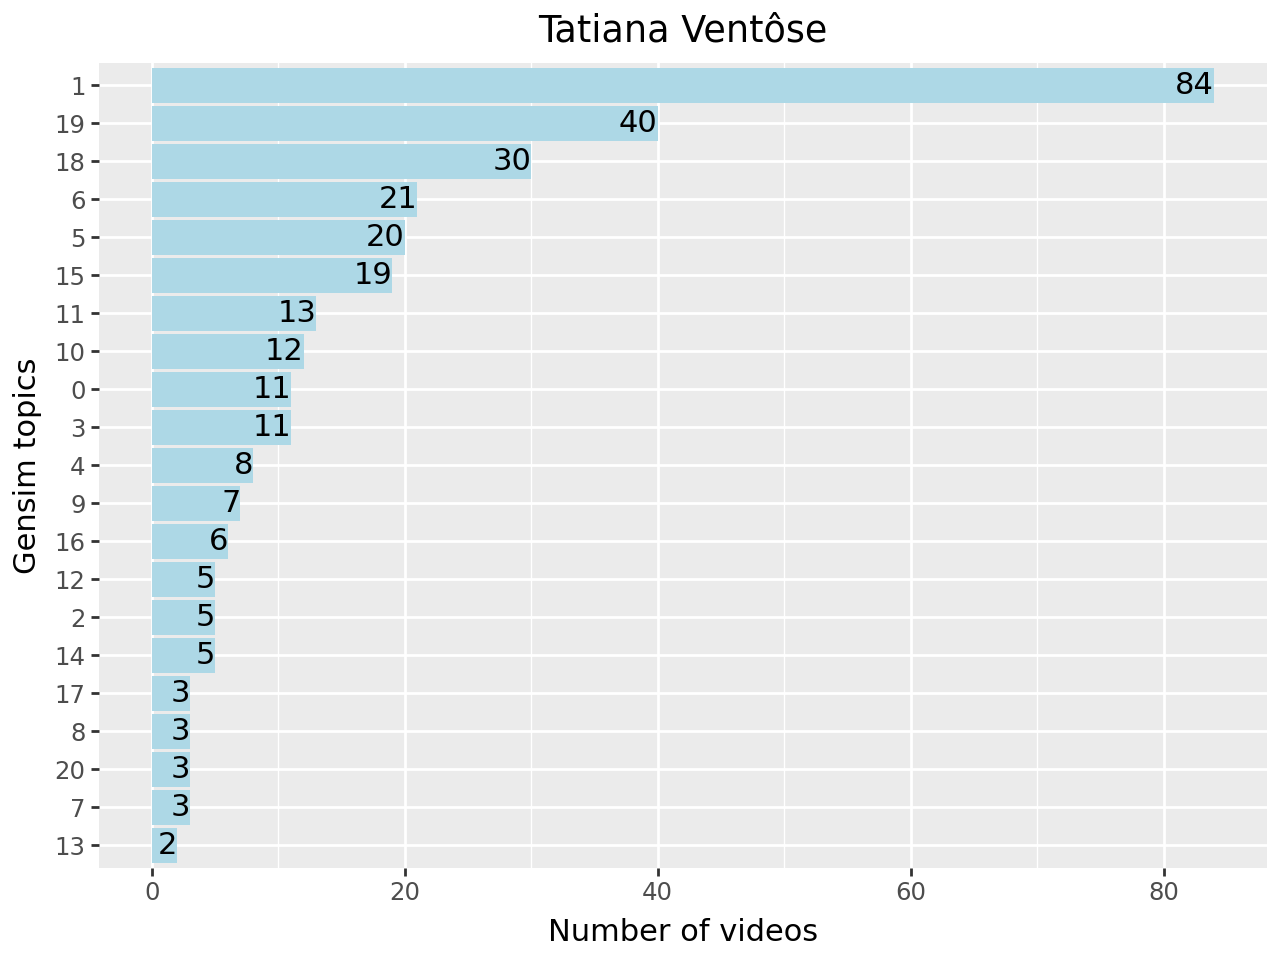

In [19]:
gt_counts = videos['gensim_topics'].explode().value_counts().sort(by="count")
p = (
    ggplot(gt_counts, aes(x='gensim_topics', y='count')) 
    + geom_col(fill='lightblue')
    + coord_flip() 
    + geom_text(aes(label='count'), va='center', ha='right', format_string='{:.0f}') 
    + labs(title=ytb_name, x="Gensim topics", y="Number of videos") 
    + scale_x_discrete(limits=gt_counts['gensim_topics'].to_list())
)
p.show()

shape: (6, 2)
┌───────────────┬───────┐
│ gensim_topics ┆ count │
│ ---           ┆ ---   │
│ str           ┆ u32   │
╞═══════════════╪═══════╡
│ 6             ┆ 1     │
│ 9             ┆ 1     │
│ 5             ┆ 2     │
│ 10            ┆ 3     │
│ 1             ┆ 7     │
│ 19            ┆ 10    │
└───────────────┴───────┘


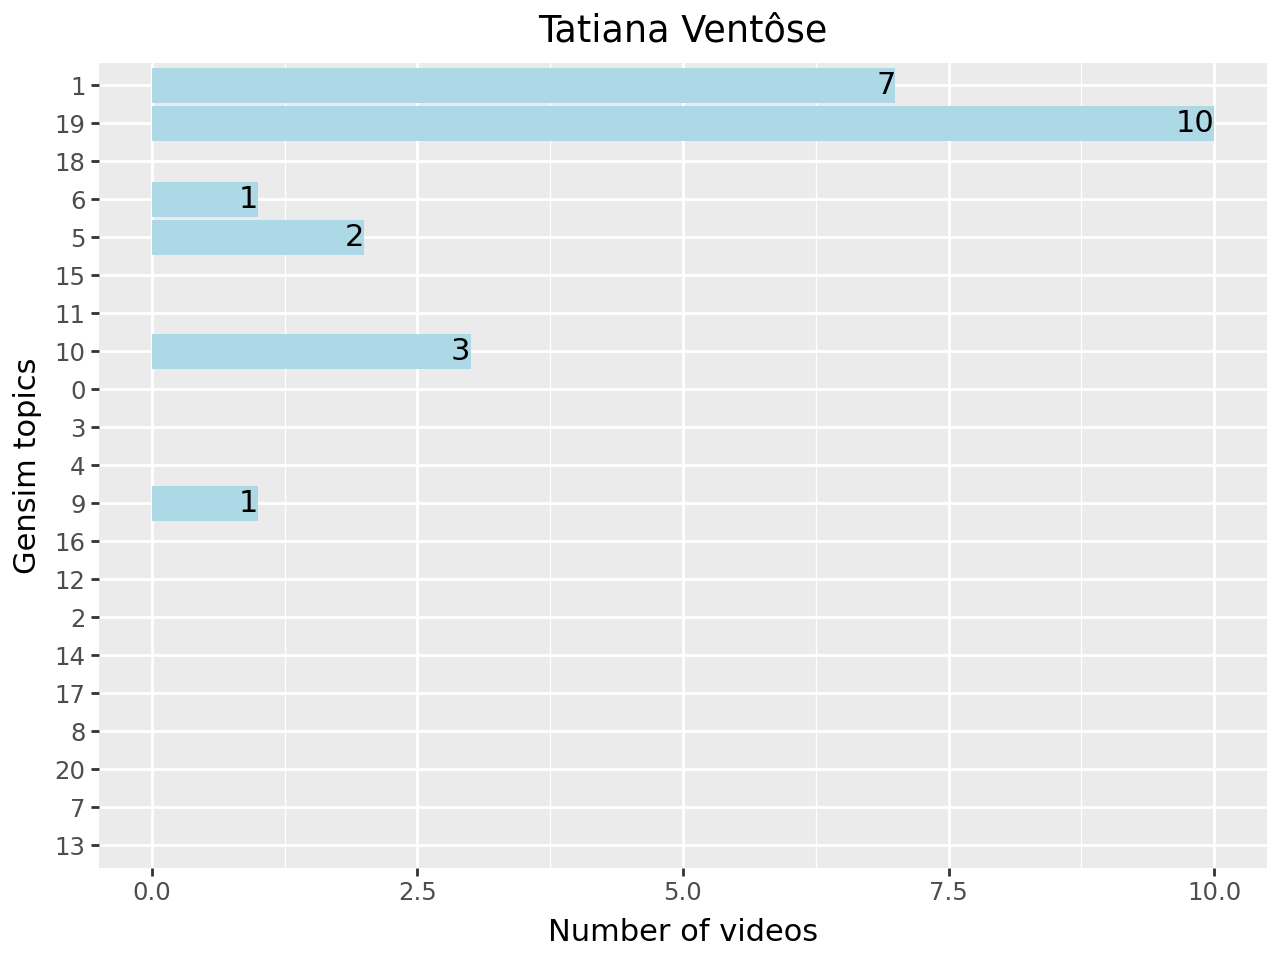

In [25]:
year = 2023 # choose a year
filtered_videos = videos.filter(pl.col('published_at').is_between(pl.date(year, 1, 1), pl.date(year, 12, 31)))
tc = filtered_videos['gensim_topics'].explode().value_counts().sort(by='count')
print(tc)

p = (
    ggplot(tc, aes(x='gensim_topics', y='count')) 
    + geom_col(fill='lightblue') 
    + coord_flip() 
    + geom_text(aes(label='count'), va='center', ha='right', format_string='{:.0f}') 
    + labs(title=ytb_name, x="Gensim topics", y="Number of videos") 
    + scale_x_discrete(limits=gt_counts['gensim_topics'].to_list())
)
p.show()

In [20]:
# gensim topic and title
gen_topics = pl.read_csv("./corpus/gensim/model_topics.csv").with_columns(
    pl.col("topic_terms").str.split(by="|").list.slice(0, length=12).list.join(", "),
    pl.col("gensim_topics").cast(pl.String)
)

videos.explode(
    "gensim_topics"
).group_by(
    "gensim_topics"
).agg(
    pl.col("video_id").len().alias("videos")
).join(
    gen_topics.drop("topic_terms"), on="gensim_topics"
).select(
    ["gensim_topics", "topic_name", "videos"]
).sort(
    "videos", descending=True
)

gensim_topics,topic_name,videos
str,str,u32
"""1""","""Politique Française""",84
"""19""","""Economie""",40
"""18""","""YouTube""",30
"""6""","""Santé""",21
"""5""","""Ukraine""",20
…,…,…
"""7""","""Pouvoir Législatif""",3
"""8""","""Armée""",3
"""17""","""Ecologie""",3


In [35]:
videos.explode("gensim_topics").group_by("gensim_topics").agg("category").with_columns(pl.col("category").list.unique()).join(gt_count, on="gensim_topics").sort("somme", descending=True)

gensim_topics,category,somme
str,list[str],u32
"""1""","[""Film & Animation "", ""News & Politics""]",84
"""19""","[""News & Politics"", ""Film & Animation ""]",40
"""18""","[""News & Politics"", ""Film & Animation ""]",30
"""6""","[""News & Politics"", ""Film & Animation ""]",21
"""5""","[""Film & Animation "", ""News & Politics""]",20
"""15""","[""Film & Animation "", ""News & Politics""]",19
"""11""","[""Film & Animation "", ""News & Politics""]",13
"""10""","[""News & Politics"", ""Film & Animation ""]",12
"""0""","[""News & Politics"", ""Film & Animation ""]",11


In [36]:
videos.explode("gensim_topics").group_by("gensim_topics").agg(pl.col("topics").flatten()).with_columns(pl.col("topics").list.unique()).join(gt_count, on="gensim_topics").sort("somme", descending=True)

gensim_topics,topics,somme
str,list[str],u32
"""1""","[""Not_provided"", ""Television_program"", … ""Health""]",84
"""19""","[""Society"", ""Fashion"", … ""Not_provided""]",40
"""18""","[""Rock_music"", ""Music"", … ""Lifestyle_(sociology)""]",30
"""6""","[""Business"", ""Politics"", … ""Not_provided""]",21
"""5""","[""Politics"", ""Society"", … ""Television_program""]",20
"""15""","[""Entertainment"", ""Television_program"", … ""Film""]",19
"""11""","[""Politics"", ""Society"", ""Not_provided""]",13
"""10""","[""Not_provided"", ""Politics"", ""Society""]",12
"""0""","[""Entertainment"", ""Television_program"", … ""Society""]",11
